# Shepherd moon simulation

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import scipy.integrate

import matplotlib.animation as anim
from IPython.display import HTML
import cv2
import skvideo.io

In [2]:
#set shepherd moon position
m = 2e-9
e = 0.002
v = 2 - 1./(1-e)
r = 1 + e
x0 = np.array([0, r, 0, v, 0, 0])
n = 100000
x = np.zeros((n, 6))
x[0,:] = x0

#populate the segment of the ring with particles
lower_range = 0.993
width = 0.003
rho = width * np.random.rand(n-1) + lower_range
spread_d = -0.2 + np.pi/2
spread_u = 0.4 + np.pi/2
phi = 2 * (spread_u-spread_d) * np.random.rand(n-1) + spread_d
v = np.sqrt(1./rho)
x[1:,0] = rho * np.cos(phi)
x[1:,1] = rho * np.sin(phi)
x[1:,3] = v   * np.sin(phi)
x[1:,4] = v   * -np.cos(phi)

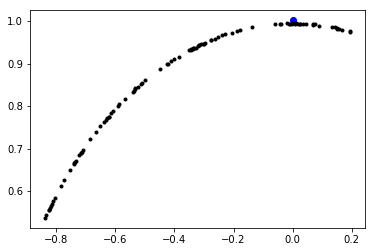

In [3]:
plt.plot(x[0,0], x[0,1], 'ob')
for i in range(1, n, 1000):
    plt.plot(x[i,0], x[i,1], '.k')

In [4]:
def f(x, t):
    x = x.reshape(n, 6)
    r = np.sqrt((x[:,:3]**2).sum(axis=1))
    g = -x[:,:3] / r.reshape(-1, 1) **3
    r0 = np.sqrt(((x[1:,:3] - x[:1,:3])**2).sum(axis=1))
    g0 = -m * (x[1:,:3] - x[:1,:3]) / r0.reshape(-1, 1) **3
    dx = np.zeros_like(x)
    dx[:,:3] = x[:,3:]
    dx[:,3:] = g
    dx[1:,3:] += g0
    return dx.ravel()

n_steps = 400
t = np.linspace(0, 2*np.pi*4, n_steps)
#run ode integrator
res = scipy.integrate.odeint(f, x.ravel(), t=t)
res = res.reshape(n_steps, n, 6)

#project to 2d
x = res[:, :, :2]
#map to polar
rho = np.sqrt((x**2).sum(axis=2))
phi = np.arctan2(x[:,:,1], x[:,:,0])
#rotate
phi = phi + t.reshape(-1, 1)
#back to cartesian
#also change notation x[:] -> x,y
x = rho * np.cos(phi)
y = rho * np.sin(phi)

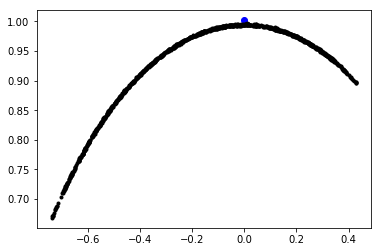

In [5]:
#inspect the end result
def plot(i):
    #plt.xlim((0.90, 1.05))
    #plt.ylim((-0.2, 0.2))
    plt.plot(x[i,0], y[i,0], 'ob')
    for j in range(1, n, 100):
        plt.plot(x[i,j], y[i,j], '.k')

plot(n_steps-1)
plt.show()

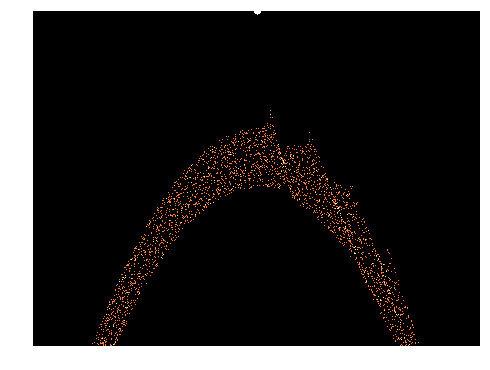

In [6]:
#render one frame
frame_width  = 2*640
frame_height = 2*480

particle_color = (1.5, 0.5, 0.3)
blur = 0

l_border = -0.2
r_border = 0.2
u_border = 0.985
d_border = 1.002

def draw_frame(x, y, frame_width=frame_width, frame_height=frame_height, blur=blur):
    x_ = ((x - l_border) / (r_border - l_border) * frame_width).astype(np.long)
    y_ = ((y - d_border) / (u_border - d_border) * frame_height).astype(np.long)
    def inside(x, y):
        return x > 0 and y > 0 and x < frame_width and y < frame_height
    frame = np.zeros((frame_height, frame_width, 3))
    for j in range(1, n):
        if inside(x_[j], y_[j]):
            frame[y_[j], x_[j]] += particle_color
    if blur > 0:
        frame = cv2.GaussianBlur(frame, ksize=(7, 7), sigmaX=blur)
    cv2.circle(frame, (x_[0], y_[0]), 10, color=(1, 1, 1), thickness=-1)
    frame[frame>1] = 1
    return frame

frame = draw_frame(x[-1], y[-1])
plt.figure(figsize=(8, 12))
plt.imshow(frame)
plt.axis('off')
plt.show()

In [14]:
#record the video
outputdict = {'-b': '300000000'}
writer = skvideo.io.FFmpegWriter("out.mp4", outputdict=outputdict)
for i in range(n_steps):
    frame = draw_frame(x[i], y[i], blur=0.5)
    writer.writeFrame(255*frame)
writer.close()

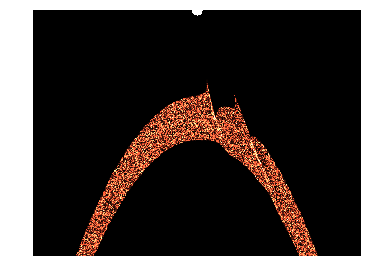

In [12]:
#save frames to create gif
from PIL import Image
for i in range(100, 200):
    frame = draw_frame(x[i], y[i], 640, 480, 0.5)
    img = Image.fromarray(np.uint8(255*frame))
    img.save('frames/img%3d.jpg' % i)
plt.imshow(img)
plt.axis('off')
plt.tight_layout()

In [15]:
#display gif
from IPython.display import HTML
HTML('<img src="out.gif">')